In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise import accuracy
from tqdm import tqdm

# 1. 데이터 로드 함수
def load_data(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            review = json.loads(line.strip())
            data.append((review['user_id'], review['business_id'], review['stars']))
    return data

# 2. 데이터 로드
train_data = load_data("train_data.json")
proposal_data = load_data("review_deberta.json")

# 3. DataFrame 변환
reader = Reader(rating_scale=(1, 5))
train_df = pd.DataFrame(train_data, columns=["user_id", "business_id", "stars"])
proposal_df = pd.DataFrame(proposal_data, columns=["user_id", "business_id", "stars"])

# 4. Surprise Dataset 생성
trainset_existing = Dataset.load_from_df(train_df, reader).build_full_trainset()
trainset_proposal = Dataset.load_from_df(proposal_df, reader).build_full_trainset()

testset_existing = trainset_existing.build_testset()
testset_proposal = trainset_proposal.build_testset()

# 5. 실험 파라미터
k_list = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
results = {"UBCF": {"existing": [], "proposal": []},
           "IBCF": {"existing": [], "proposal": []},
           "SVD":  {"existing": [], "proposal": []}}

# 6. UBCF
for k in tqdm(k_list, desc="UBCF"):
    model = KNNBasic(k=k, sim_options={"name": "cosine", "user_based": True})
    model.fit(trainset_existing)
    mae_exist = accuracy.mae(model.test(testset_existing), verbose=False)
    model.fit(trainset_proposal)
    mae_prop = accuracy.mae(model.test(testset_proposal), verbose=False)
    results["UBCF"]["existing"].append(mae_exist)
    results["UBCF"]["proposal"].append(mae_prop)

# 7. IBCF
for k in tqdm(k_list, desc="IBCF"):
    model = KNNBasic(k=k, sim_options={"name": "cosine", "user_based": False})
    model.fit(trainset_existing)
    mae_exist = accuracy.mae(model.test(testset_existing), verbose=False)
    model.fit(trainset_proposal)
    mae_prop = accuracy.mae(model.test(testset_proposal), verbose=False)
    results["IBCF"]["existing"].append(mae_exist)
    results["IBCF"]["proposal"].append(mae_prop)

# 8. SVD
for k in tqdm(k_list, desc="SVD"):
    model = SVD(n_factors=k)
    model.fit(trainset_existing)
    mae_exist = accuracy.mae(model.test(testset_existing), verbose=False)
    model.fit(trainset_proposal)
    mae_prop = accuracy.mae(model.test(testset_proposal), verbose=False)
    results["SVD"]["existing"].append(mae_exist)
    results["SVD"]["proposal"].append(mae_prop)


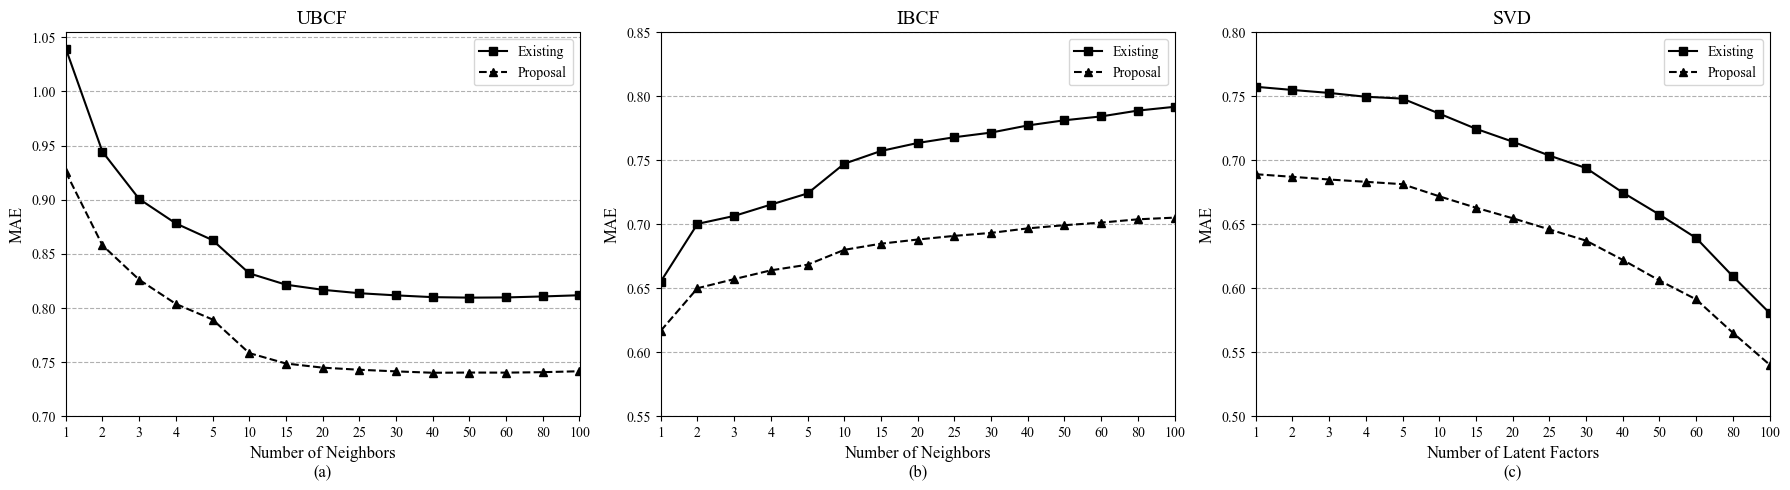

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # sharey=False

models = ["UBCF", "IBCF", "SVD"]
x_pos = list(range(len(k_list)))
x_labels = k_list

for i, model in enumerate(models):
    y_exist = results[model]["existing"]
    y_prop = results[model]["proposal"]
    axes[i].set_title(f"{model}", fontsize=14)
    axes[i].set_facecolor("white") 

    axes[i].plot(x_pos, y_exist, label="Existing", linestyle="-", marker="s", color="black")
    axes[i].plot(x_pos, y_prop, label="Proposal", linestyle="--", marker="^", color="black")

    x_label = "Number of Neighbors" if model != "SVD" else "Number of Latent Factors"
    axes[i].set_xlabel(f"{x_label}\n({chr(97 + i)})", fontsize=12)
    axes[i].set_ylabel("MAE", fontsize=12)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(x_labels, rotation=0)

    ymin = min(y_exist + y_prop)
    ymax = max(y_exist + y_prop)
    y_start = np.floor(ymin * 20) / 20
    y_end = np.ceil(ymax * 20) / 20

    while (y_end - y_start) < 0.3:
        y_start -= 0.05
        y_end += 0.05

    y_ticks = np.round(np.arange(y_start, y_end + 0.001, 0.05), 2)
    axes[i].set_yticks(y_ticks.tolist())

    axes[i].grid(axis="y", linestyle="--")
    axes[i].set_xlim(0, len(k_list) - 1)
    axes[i].legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

result_df = pd.DataFrame({
    "k": k_list,
    "UBCF_Existing": results["UBCF"]["existing"],
    "UBCF_Proposal": results["UBCF"]["proposal"],
    "IBCF_Existing": results["IBCF"]["existing"],
    "IBCF_Proposal": results["IBCF"]["proposal"],
    "SVD_Existing":  results["SVD"]["existing"],
    "SVD_Proposal":  results["SVD"]["proposal"]
})

print(result_df.to_string(index=False))

# 각 모델별 최적의 k 값과 MAE
def get_best_k(model_name):
    best_k = k_list[results[model_name]["existing"].index(min(results[model_name]["existing"]))]  # 최저 MAE 값의 k
    best_mae = min(results[model_name]["existing"])
    return best_k, best_mae

print("\n--- 최적의 k 값과 MAE ---")
for model in ["UBCF", "IBCF", "SVD"]:
    best_k, best_mae = get_best_k(model)
    print(f"{model} - 최적의 k: {best_k}, MAE: {best_mae:.4f}")

  k  UBCF_Existing  UBCF_Proposal  IBCF_Existing  IBCF_Proposal  SVD_Existing  SVD_Proposal
  1       1.039646       0.925658       0.655311       0.616856      0.757460      0.689160
  2       0.944308       0.857898       0.700346       0.650080      0.754979      0.687111
  3       0.900711       0.826147       0.706546       0.657192      0.752664      0.685019
  4       0.878142       0.803806       0.715412       0.664051      0.749664      0.683216
  5       0.862724       0.789411       0.724128       0.668454      0.748217      0.681357
 10       0.832043       0.758382       0.747345       0.680060      0.736507      0.671884
 15       0.821569       0.748774       0.757296       0.684872      0.724641      0.662985
 20       0.816857       0.744951       0.763550       0.688121      0.714594      0.654759
 25       0.813698       0.743001       0.768031       0.690982      0.703737      0.646027
 30       0.811704       0.741507       0.771668       0.693304      0.693957   